In [102]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plot
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
)
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

Open 'laliga.sqlite' data file.

In [60]:
dir = Path.cwd()
laliga_path = dir.parent / "laliga.sqlite"
if laliga_path.exists() == False:
        raise FileNotFoundError(
            f"Not found 'laliga.sqlite' neither in {laliga_path} nor in {parent_path}"
        )
    
try:
     conn = sqlite3.connect(laliga_path)
except sqlite3.OperationalError as e:
    print(f"Could not connect to data base 'laliga.sqlite'.")

In [61]:
df = pd.read_sql("SELECT * FROM Matches;", conn)
df

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
48775,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
48776,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
48777,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
48778,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None


We clean the data det by removing NaN scores and define *home_goals* and *away_goals*.

In [62]:
matches = df.copy()
valid_matches = matches[matches['score'].notna() & matches['score'].str.contains(':')].copy()
valid_matches[['home_goals', 'away_goals']] = (valid_matches['score'].str.split(':', expand=True).astype(int))

In [63]:
def get_result(row):
    if row['home_goals'] > row['away_goals']:
        return '1'
    elif row['home_goals'] < row['away_goals']:
        return '2'
    else:
        return 'X' 

In [64]:
valid_matches['result'] = valid_matches.apply(get_result, axis=1)

In [65]:
def generate_date(row):
    date = row['date'].split("/")
    month = date[0]
    day = date[1]
    year = date[2]
    season = row['season'].split("-")[0]
    year = season[0:2] + year
    return f"{month}/{day}/{year}"

In [66]:
valid_matches["date"] = valid_matches.apply(generate_date, axis=1)

In [67]:
valid_matches[["month", "day", "year"]] = valid_matches["date"].str.split("/", expand=True).astype(int)

In [ ]:
valid_matches = valid_matches.drop(columns=["season", "date", "score", "time", "home_goals", "away_goals"])

       division  matchday        home_team        away_team result  month  \
0             1         1      Arenas Club  Athletic Madrid      2      2   
1             1         1         Espanyol       Real Unión      1      2   
2             1         1      Real Madrid        Catalunya      1      2   
3             1         1         Donostia         Athletic      X      2   
4             1         1           Racing        Barcelona      2      2   
...         ...       ...              ...              ...    ...    ...   
48345         2         3     Ponferradina           Girona      1      8   
48346         2         3    SD Amorebieta       UD Almería      1      8   
48347         2         3          CD Lugo  Real Valladolid      2      8   
48348         2         3  Real Sociedad B   CF Fuenlabrada      X      8   
48349         2         3        Burgos CF         SD Eibar      2      8   

       day  year  
0       10  1929  
1       10  1929  
2       10  1929  

In [69]:
teams = pd.unique(valid_matches[["home_team", "away_team"]].values.ravel())

In [70]:
encoder = OneHotEncoder(handle_unknown="ignore", categories=[teams, teams])

In [71]:
encoded = encoder.fit_transform(valid_matches[["home_team", "away_team"]])

In [72]:
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(["home_team", "away_team"]))

In [73]:
valid_matches = valid_matches.drop(columns=["home_team", "away_team"])

In [88]:
df_train = pd.concat([
    encoded_df.reset_index(drop=True),
    valid_matches.reset_index(drop=True)
], axis=1)

df_train = df_train.loc[df_train["year"] < 2021]

In [89]:
print(df_train)

       home_team_Arenas Club  home_team_Athletic Madrid  home_team_Espanyol  \
0                        1.0                        0.0                 0.0   
1                        0.0                        0.0                 1.0   
2                        0.0                        0.0                 0.0   
3                        0.0                        0.0                 0.0   
4                        0.0                        0.0                 0.0   
...                      ...                        ...                 ...   
47680                    0.0                        0.0                 0.0   
47681                    0.0                        0.0                 0.0   
47682                    0.0                        0.0                 0.0   
47683                    0.0                        0.0                 0.0   
47684                    0.0                        0.0                 0.0   

       home_team_Real Unión  home_team_Real Madrid 

In [90]:
y_train = df_train["result"]
X_train = df_train.drop("result", axis=1)

In [ ]:
gradient_boosting = GradientBoostingClassifier()
random_forest = RandomForestClassifier(random_state=42)

In [ ]:
# gradient_boosting.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [91]:
df_test = pd.concat([
    encoded_df.reset_index(drop=True),
    valid_matches.reset_index(drop=True)
], axis=1)
df_test = df_test.loc[df_test["year"] >= 2021]

In [92]:
y_test = df_test["result"]
X_test = df_test.drop("result", axis=1)

In [ ]:
y_pred = random_forest.predict(X_test)

Accuracy on test Gradient Boosting Classifier: 0.4648


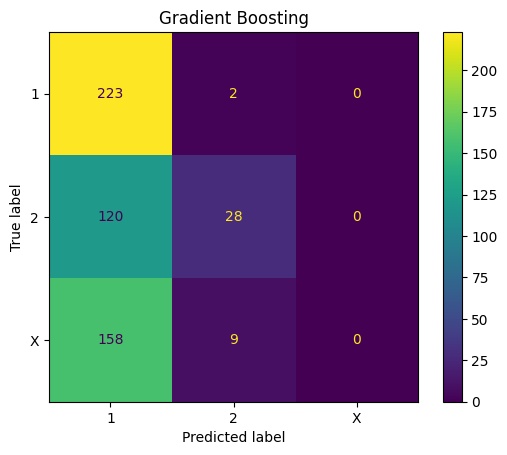

In [100]:
feature_names = sorted(y_test.unique())
conf_mat_liblinear = confusion_matrix(y_test, y_pred, labels=feature_names)
disp_liblinear = ConfusionMatrixDisplay(confusion_matrix=conf_mat_liblinear, display_labels=feature_names)
disp_liblinear.plot()
plot.title("Gradient Boosting")
plot.savefig("confusion_matrix.png", dpi=300)

print(f"Accuracy on test Gradient Boosting Classifier: {accuracy_score(y_test, y_pred):.4f}")

In [101]:
df_test.shape

(540, 310)